In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Installing packages and libraries

In [ ]:
pip install scikit-learn

In [ ]:
pip install timezonefinder

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
import sklearn
import sklearn.neighbors

from bs4 import BeautifulSoup
from tqdm import tqdm
from time import sleep
from datetime import date, datetime
from google.colab import files

from geopy.geocoders import Nominatim
nom = Nominatim()

from timezonefinder import TimezoneFinder
tf = TimezoneFinder()

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


## 2. Importing and cleaning dataset

In [ ]:
#importing datasets
projects = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/all_projects_data.csv')
hacks = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/hacks_data.csv')
participants = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/participants.csv')
participants_locations = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/all_locations_cleaned.csv')

participants_locations = participants_locations[['country', 'lat', 'lon']] #from whole table we are interested only in country, lat and lon

#deleting duplicates
projects.drop_duplicates(inplace=True)
hacks.drop_duplicates(inplace=True)
participants.drop_duplicates(inplace=True)
participants_locations.drop_duplicates(inplace=True)

hacks = hacks.rename(columns={"submission_gallery_url": "submission_gal_url"}, errors="raise") 
hacks = hacks[~hacks['submission_gal_url'].isnull()]
hacks.submission_gal_url = hacks.submission_gal_url.astype(str)
projects.submission_gal_url = projects.submission_gal_url.astype(str)

Transforming start dates and end dates of hackathon to datetime format to be able to calculate duration

In [ ]:
hacks['start_date_format'] = pd.to_datetime(hacks['start_date_format'])
hacks['end_date_format'] = pd.to_datetime(hacks['end_date_format'])
hacks['year'] = hacks['start_date_format'].dt.year
hacks['hack_duration'] = (hacks['end_date_format'] - hacks['start_date_format']).dt.days

Defining location as offline if hackathon was not online

In [ ]:
hacks.loc[hacks['Location'] != 'Online', 'Location'] = 'Offline' 

I think this part should be after hacks data cleaning

In [ ]:
# data = projects.merge(hacks, on='submission_gal_url', how='left') #create after data cleaning!

We consider group of people to contain at least 3 people in a team, so all projects that are done by 1 or 2 people are removed

In [ ]:
projects['participants_num'] = projects['participants_num'].replace({'Nan':np.nan, '': np.nan})
col = np.array(projects['participants_num'].fillna(-999), np.int16)
projects['participants_num'] = col
projects['participants_num'] = projects['participants_num'].replace(-999, np.nan)
projects.sort_values('participants_num', ascending=False, inplace=True)

projects = projects[projects['participants_num']>=3]

As far as we are going to investigate intergroup distance we are also going to remove all participants who has no location specified in their profile

In [ ]:
# we will delete participants without countries from the dataset
participants = participants[participants['country'] != 'Nan']
participants['country'].replace({'J & K': 'India', "Ari'el": 'Israel'}, inplace=True)

And we are also going to delete participants who specified only country in their location, becasue it will make it impossible to calculate accurate distance between group members, especially time zone difference

In [ ]:
#WRITE CODE HERE
participants = participants[participants['country'].str.split(',').str.len()>1] #after this step we've got 199360 unique participants out of 280472 which is gooood!
participants_locations = participants_locations[participants_locations['country'].str.split(',').str.len()>1] #after this step we've got 11914 unique ;ocations out of 12209 which is gooood!

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


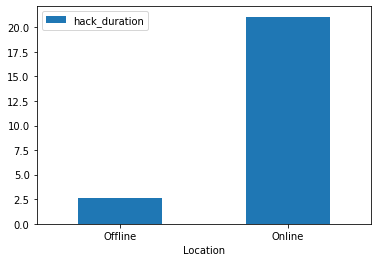

In [ ]:
test_3 = hacks[['hack_duration', 'Location', 'start_date_format']]
test_3.loc[test_3['Location'] != 'Online', 'Location'] = 'Offline' 

N_top = 20

grouped_criteria = test_3.groupby('Location').mean() #add error bar and standart deviation, min, max
grouped_criteria = grouped_criteria.iloc[:N_top, :]

grouped_criteria.plot.bar(rot=0)

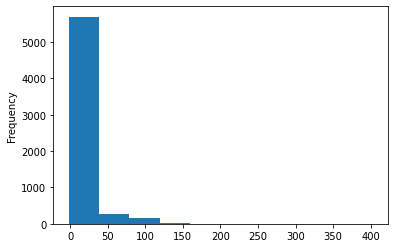

In [ ]:
hacks['hack_duration'].plot.hist(rot=0)

In [ ]:
hacks[hacks['hack_duration']>21] #there are 609  hacks out of 6052 with duration longer than 21 day, so only 10% and we can remove them

,URL,Criteria,schedule,hack_type,info,start_date_format,end_date_format,Prizes,prize_money,Id,Title,Location,start_date,end_date,year,themes,prize,registered_N,featured,organization_name,winners_announced,submission_gal_url,start_a_submission_url,hack_duration
0,https://ignition.devpost.com/,"Potential Impact, Functionality, Novelty, Desi...",Submissions August 31 at 9:15am PDT October 15...,Public,"Oct 18 – 22, 2021, Online, Public, Solana Capi...",2021-08-31,2021-10-16,"Grand Prize Winner, Community Choice Award, Co...","$5,120,000",13240.0,IGNITION | A Global Solana Hackathon,Online,Aug 31,Oct 16,2021,Blockchain,"$19,000",5867.0,False,Solana Capital,False,https://ignition.devpost.com/project-gallery,https://ignition.devpost.com/challenges/start_...,46
1,https://azure-sentinel-hackathon-2021.devpost....,"Quality of Idea, Value to Enterprise, Technica...",Submissions June 21 at 9:30am PDT October 04 a...,Public,"Oct 7 – 25, 2021, Online, Public, Microsoft, C...",2021-06-21,2021-10-04,"First Prize, Second Prize, Runner Up ...","$19,000",12634.0,Azure Sentinel Hackathon 2021,Online,Jun 21,Oct 04,2021,Cybersecurity,"$19,000",499.0,False,Microsoft,False,https://azure-sentinel-hackathon-2021.devpost....,https://azure-sentinel-hackathon-2021.devpost....,105
6,https://awsgraviton.devpost.com/,"Quality of the Idea, Potential Value, Implemen...",Submissions August 24 at 10:15am EDT October 1...,Public,"Oct 29, 2021, Online, Public, Amazon, Enterpri...",2021-08-24,2021-10-13,"Best New App, Runner Up - New App, Third Place...","$50,000",13116.0,AWS Graviton Hackathon,Online,Aug 24,Oct 13,2021,"Enterprise, Gaming, Machine Learning/AI","$19,000",1282.0,False,Amazon,False,https://awsgraviton.devpost.com/project-gallery,https://awsgraviton.devpost.com/challenges/sta...,50
9,https://housestudentapps.devpost.com/,"Quality of the Idea, Implementation, Programmi...",Submissions February 01 at 9:00am EST May 31 a...,Public,"Jun 15, 2014, Online, Public",2014-02-01,2014-05-31,"District Winner, Honorable Mention",no money prize,820.0,House Student App Challenge,Online,Feb 01,May 31,2014,NaN,"$19,000",1211.0,False,NaN,False,https://housestudentapps.devpost.com/project-g...,https://housestudentapps.devpost.com/challenge...,119
12,https://bsvhackathon.devpost.com/,"TECHNOLOGY, DESIGN, MARKET FIT, COMPLETION",Submissions June 14 at 10:00am CEST July 26 at...,Public,"Oct 19, 2021, Online, Public, Bitcoin Associat...",2021-06-14,2021-07-26,"1ST PLACE, 2ND PLACE, 3RD PLACE","$100,000",12470.0,Bitcoin SV Hackathon 2021,Online,Jun 14,Jul 26,2021,Blockchain,"$19,000",654.0,False,Bitcoin Association,False,https://bsvhackathon.devpost.com/project-gallery,https://bsvhackathon.devpost.com/challenges/st...,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860,https://prom-nov15.devpost.com/,"Idea, Implementation, Presentation",Submissions November 04 at 9:00pm PST December...,Public,"Nov 4 – Dec 2, 2015, University of California,...",2015-11-05,2015-12-02,First Place,$200,3157.0,CSES Project of the Month (PROM) - November 2015,Offline,Nov 05,Dec 02,2015,NaN,"$19,000",16.0,False,NaN,True,https://prom-nov15.devpost.com/project-gallery,https://prom-nov15.devpost.com/challenges/star...,27
5908,https://gctechspacepebble.devpost.com/,"Pebble Watch Central, Technical challenge, Use...",Submissions February 18 at 6:00pm AEST March 1...,Public,"Feb 18 – Mar 18, 2015, Robina, Australia, Public",2015-02-18,2015-03-18,Pebble Watch (3),$297,2005.0,GCTechSpace Pebble Watch Makerthon,Offline,Feb 18,Mar 18,2015,NaN,"$19,000",14.0,False,NaN,True,https://gctechspacepebble.devpost.com/project-...,https://gctechspacepebble.devpost.com/challeng...,28
5910,https://employment.devpost.com/,"Use of Required Data, Technical Implementation...",Submissions July 14 at 12:00am EDT September 1...,Public,"Jul 14 – Sep 14, 2011, Online, Public",2011-07-14,2011-09-14,"First Place, Second Place, Third Place, Honora...","$33,500",202.0,Occupati

In [ ]:
hacks = hacks[hacks['hack_duration']<21] #we deleted all hacks that last more than 21 day
hacks = hacks[hacks['hack_duration']>=0] #we also deleted hacks that last less than 0 days, becasue it simply means that start and end date were not correct

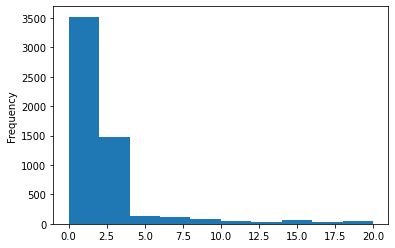

In [ ]:
hacks['hack_duration'].plot.hist(rot=0)

After this our data look the following way

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


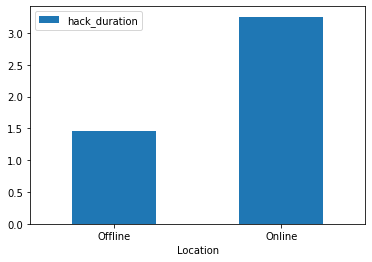

In [ ]:
test_3 = hacks[['hack_duration', 'Location', 'start_date_format']]
test_3.loc[test_3['Location'] != 'Online', 'Location'] = 'Offline' 

grouped_criteria = test_3.groupby('Location').mean()
grouped_criteria.plot.bar(rot=0)

In [ ]:
#we can see that some projects were submitted to multiple hackathons, for example https://devpost.com/software/005_hilfsmittelverteilung_ja or https://devpost.com/software/15_simply_happy and therefore we will remove duplicates from project links (submission gallery is different one) and keep only first submission
projects = projects.merge(hacks, on='submission_gal_url', how='left')
projects.sort_values(by = ['project_URL', 'start_date_format'], ascending = [True, True], inplace = True)
projects.drop_duplicates('project_URL', inplace=True)
# project_dupl[project_dupl['project_URL']=='https://devpost.com/software/break-ly-podic8'] this row was to check that only one project with the earliest hack date was saved
#example https://devpost.com/software/break-ly-podic8
#after this step we now have 166895 projects in total

In [ ]:

projects = projects[projects['hack_duration']<21] #we deleted also all projects that were created in hacks that last more than 21 day
projects = projects[projects['hack_duration']>=0] #and projects that were created in hacks  that last less than 0 days, becasue it simply means that start and end date were not correct

In [ ]:
projects

,submission_gal_url,project_URL,github_links,participants,participants_num,build_with,repo_link,repo,submitted_to_link,submitted_to_name,submitted_to_hacks_num,likes,comments,URL,Criteria,schedule,hack_type,info,start_date_format,end_date_format,Prizes,prize_money,Id,Title,Location,start_date,end_date,year,themes,prize,registered_N,featured,organization_name,winners_announced,start_a_submission_url,hack_duration
19938,https://hackatmacs.devpost.com/project-gallery,https://devpost.com/software/--10,NaN,"https://devpost.com/glaba13, https://devpost.c...",4.0,"arduino, hardware",Nan,Nan,https://hackatmacs.devpost.com/,hack@MACS,1.0,0,0,https://hackatmacs.devpost.com/,"იდეა, შესრულების დონე, ტექნოლოგიური გადაწყვეტა...",Submissions March 14 at 5:00am GET March 16 at...,Public,"Mar 14 – 16, 2014, Tbilisi, Georgia, Public",2014-03-13,2014-03-16,"პირველი ადგილი, მეორე ადგილი, მესამე ადგილი, მ...","10,000GEL",891.0,hack@MACS,Offline,Mar 13,16,2014.0,NaN,"19,000",165.0,False,NaN,True,https://hackatmacs.devpost.com/challenges/star...,3.0
20117,https://hackatmacs.devpost.com/project-gallery,https://devpost.com/software/--11,NaN,"https://devpost.com/Crazy_infernus, https://de...",4.0,"android, bootstrap, codeigniter, css, html, ja...",http://192.168.85.133/,192.168.85.133,https://hackatmacs.devpost.com/,hack@MACS,1.0,0,0,https://hackatmacs.devpost.com/,"იდეა, შესრულების დონე, ტექნოლოგიური გადაწყვეტა...",Submissions March 14 at 5:00am GET March 16 at...,Public,"Mar 14 – 16, 2014, Tbilisi, Georgia, Public",2014-03-13,2014-03-16,"პირველი ადგილი, მეორე ადგილი, მესამე ადგილი, მ...","10,000GEL",891.0,hack@MACS,Offline,Mar 13,16,2014.0,NaN,"19,000",165.0,False,NaN,True,https://hackatmacs.devpost.com/challenges/star...,3.0
19914,https://hackatmacs.devpost.com/project-gallery,https://devpost.com/software/--12,NaN,"https://devpost.com/Gogishvili, https://devpos...",4.0,android,Nan,Nan,https://hackatmacs.devpost.com/,hack@MACS,1.0,0,0,https://hackatmacs.devpost.com/,"იდეა, შესრულების დონე, ტექნოლოგიური გადაწყვეტა...",Submissions March 14 at 5:00am GET March 16 at...,Public,"Mar 14 – 16, 2014, Tbilisi, Georgia, Public",2014-03-13,2014-03-16,"პირველი ადგილი, მეორე ადგილი, მესამე ადგილი, მ...","10,000GEL",891.0,hack@MACS,Offline,Mar 13,16,2014.0,NaN,"19,000",165.0,False,NaN,True,https://hackatmacs.devpost.com/challenges/star...,3.0
20105,https://hackatmacs.devpost.com/project-gallery,https://devpost.com/software/--9,NaN,"https://devpost.com/KetiZazarashvili, https://...",4.0,"adobe-illustrator, css3, html5, javascript, ph...",http://demo1236.fulba.com/,demo1236.fulba.com,https://hackatmacs.devpost.com/,hack@MACS,1.0,1,1,https://hackatmacs.devpost.com/,"იდეა, შესრულების დონე, ტექნოლოგიური გადაწყვეტა...",Submissions March 14 at 5:00am GET March 16 at...,Public,"Mar 14 – 16, 2014, Tbilisi, Georgia, Public",2014-03-13,2014-03-16,"პირველი ადგილი, მეორე ადგილი, მესამე ადგილი, მ...","10,000GEL",891.0,hack@MACS,Offline,Mar 13,16,2014.0,NaN,"19,000",165.0,False,NaN,True,https://hackatmacs.devpost.com/challenges/star...,3.0
46770,https://hacktbilisi.devpost.com/project-gallery,https://devpost.com/software/-51fko,NaN,"https://devpost.com/NikaChkhartishvili, https:...",4.0,"arduino, dc-motor, servo",Nan,Nan,https://hacktbilisi.devpost.com/,hackTBILISI,1.0,2,2,https://hacktbilisi.devpost.com/,"იდეა/Idea, ტექნიკური სირთულე/Technical difficu...",Submissions December 20 at 5:00pm GET December...,Public,"Dec 20 – 21, 2014, Location TBD, Public",2014-12-20,2014-12-21,In Prizes (9),"$5,004",1813.0,hackTBILISI,Offline,Dec 20,21,2014.0,NaN,"$19,000",106.0,False,NaN,True,https://hacktbilisi.devpost.com/challenges/sta...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69075,https://hackquarantine.devpost.com/project-gal...,https://devpost.com/software/zymptom-wi1z42,NaN,"https://devpost.com/rconrardy, https://devpost...",3.0,"adobe, adobe-illustrator, expo.io, flask, pyth..

## 2. Calculating distance between all locations

In [ ]:
# add columns with radians for latitude and longitude
participants_locations[['lat_radians','long_radians']] = (
    np.radians(participants_locations.loc[:,['lat','lon']]))

In [ ]:
# https://medium.com/@danalindquist/finding-the-distance-between-two-lists-of-geographic-coordinates-9ace7e43bb2f
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise
    (participants_locations[['lat_radians','long_radians']],
     participants_locations[['lat_radians','long_radians']])*6371
)
# Note that  
df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=participants_locations['country'], 
                 columns=participants_locations['country'])
)

In [ ]:
def get_mean_participants_dist(projects_df, participants_df, dists_matrix_df, threshold=0.7):
  participant_county_dict = {row['0']: row['country'] for i, row in participants_df.iterrows()}

  mean_dists = []

  for participants_projects in tqdm(projects_df['participants']):
    all_participants = np.array(participants_projects.split(', '))
    contains_mask = [p in participant_county_dict for p in all_participants]

    if sum(contains_mask) / len(contains_mask) >= threshold:
      partisipants_with_countries = all_participants[contains_mask]
      dists = []

      for i, p1 in enumerate(partisipants_with_countries[ :len(partisipants_with_countries)-1]):
        for p2 in partisipants_with_countries[i+1: ]:
          p1_country = participant_county_dict[p1]
          p2_country = participant_county_dict[p2]
          dists.append(np.squeeze(dists_matrix_df.loc[p1_country, p2_country]))
      
      mean_dists.append(np.mean(dists))    
    else:
      mean_dists.append(-1)
  
  return mean_dists

In [ ]:
mean_dists = get_mean_participants_dist(projects, participants, df_dist_matrix)
projects['intergroup_spartial_dist'] = mean_dists

100%|██████████| 74297/74297 [00:06<00:00, 10659.23it/s]


As an addition to data cleaning done in previous part, we will also consider only projects that are done by group where at least 70% of people have stated their location

In [ ]:
projects = projects[projects['intergroup_spartial_dist'] != -1] # now we are having 46819 projects where we can calculate the distance between team mates (so, at least 70% of peers have cpncrete location)

## 3. Plot data insights

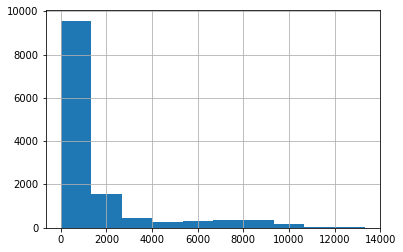

In [ ]:
# has_mean_dist = projects_with_location_status['intergroup_spartial_dist'] != -1

projects.loc[(projects['Location'] == 'Online'), 'intergroup_spartial_dist'].hist()

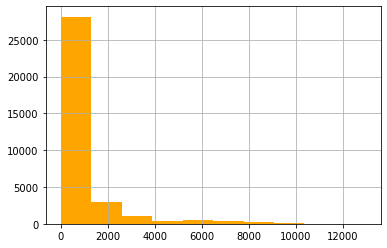

In [ ]:
projects.loc[(projects['Location'] == 'Offline'), 'intergroup_spartial_dist'].hist(color='orange')

In [ ]:
mean_online_dist = np.mean(projects.loc[(projects['Location'] == 'Online'), 'intergroup_spartial_dist'])
mean_offline_dist = np.mean(projects.loc[(projects['Location'] == 'Offline'), 'intergroup_spartial_dist'])

print(f"Mean spartial distance for online hacks: {mean_online_dist}")
print(f"Mean spartial distance for offline hacks: {mean_offline_dist}")

Mean spartial distance for online hacks: 1381.01647290228
Mean spartial distance for offline hacks: 723.2125736838101


In [ ]:
online_dists = projects.loc[(projects['Location'] == 'Online'), 'intergroup_spartial_dist'].values
offline_dists = projects.loc[(projects['Location'] == 'Offline'), 'intergroup_spartial_dist'].values

In [ ]:
# STAR NOTATIONS, HOW MANY DIGITS AFTER COMMA
from scipy import stats

stat_t, p1 = stats.ttest_ind(online_dists, offline_dists)
print(f"T-statistic: {stat_t}, p-value {p1}")

stat_u, p2 = stats.mannwhitneyu(online_dists, offline_dists)
print(f"U-statistic: {stat_u}, p-value {p2}")

T-statistic: 34.761474563391765, p-value 1.965618645142433e-261
U-statistic: 181081659.5, p-value 4.7460193012078564e-216


## 4. Time zone difference calculation

In [ ]:
tz = []
for ind, row in participants_locations.iterrows():
  try:
    zone =  tf.timezone_at(lng=row['lon'], lat=row['lat'])
    tz.append(zone)
  except:
    print(f"Timeout error in row {ind}")
    tz.append(None)

participants_locations['tz_name'] = tz
participants = participants.merge(participants_locations[['country', 'tz_name']], on='country', how='left')

In [ ]:
from pytz import timezone
import pandas as pd

def tz_diff(date, tz1, tz2):
    '''
    Returns the difference in hours between timezone1 and timezone2
    for a given date.
    '''
    date = pd.to_datetime(date) if date == 'NaT' else datetime.now()
    
    return (max(tz1.localize(date),tz2.localize(date)) - 
            min(tz1.localize(date),tz2.localize(date)).astimezone(tz1))\
            .seconds/3600

# we substitute min value from max vale, our calculation also takes into consideration DST (daylight saving time) by taking as an input date when hackathon started
# tz_diff('2021-08-01', timezone('America/Los_Angeles'), timezone('America/New_York')), tz_diff('2021-08-01', timezone('America/New_York'), timezone('America/Los_Angeles'))

In [ ]:
def get_mean_participants_dist(projects_df, participants_df, dists_matrix_df=None, threshold=0.7):
  if dists_matrix_df is not None:
    participant_info_dict = {row['0']: row['country'] for i, row in participants_df.iterrows()}
  else: 
    participant_info_dict = {row['0']: row['tz_name'] for i, row in participants_df.iterrows()}

  mean_dists = []

  for participants_projects, start_date in tqdm(zip(projects_df['participants'], projects_df['start_date_format']), total=projects_df.shape[0]):
    all_participants = np.array(participants_projects.split(', '))
    contains_mask = [p in participant_info_dict for p in all_participants]

    if sum(contains_mask) / len(contains_mask) >= threshold:
      partisipants_with_countries = all_participants[contains_mask]
      dists = []

      for i, p1 in enumerate(partisipants_with_countries[ :len(partisipants_with_countries)-1]):
        for p2 in partisipants_with_countries[i+1: ]:
          if dists_matrix_df is not None:
            p1_country = participant_info_dict[p1]
            p2_country = participant_info_dict[p2]
            dists.append(np.squeeze(dists_matrix_df.loc[p1_country, p2_country]))
          else:
            p1_tz = participant_info_dict[p1]
            p2_tz = participant_info_dict[p2]
            dists.append(tz_diff(start_date, timezone(p1_tz), timezone(p2_tz)))
      
      mean_dists.append(np.mean(dists))
    
    else:
      mean_dists.append(-1)
  
  return mean_dists

In [ ]:
tz_dists = get_mean_participants_dist(projects, participants)
projects['intergroup_tz_dist'] = tz_dists

Same as previously, we will delete groups where we were not able to calculate tz_difference at least between 70% of team members 

In [ ]:
projects = projects[projects['intergroup_tz_dist'] != -1]

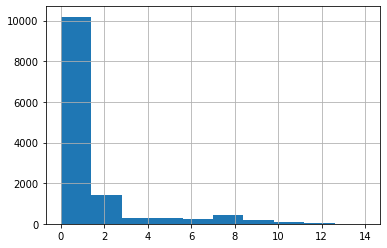

In [ ]:
data_with_location_status = projects
data_with_location_status.loc[data_with_location_status['Location'] != 'Online', 'Location'] = 'Offline'
has_mean_dist = data_with_location_status['intergroup_tz_dist'] != -1
data_with_location_status.loc[(has_mean_dist) & (data_with_location_status['Location'] == 'Online'), 'intergroup_tz_dist'].hist()

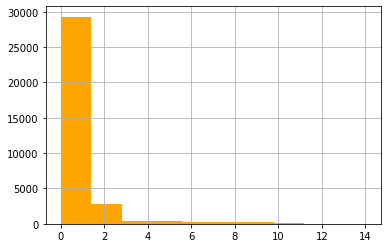

In [ ]:
data_with_location_status.loc[(has_mean_dist) & (data_with_location_status['Location'] == 'Offline'), 'intergroup_tz_dist'].hist(color='orange')

In [ ]:
mean_online_tz_dist = np.mean(data_with_location_status.loc[(has_mean_dist) & (data_with_location_status['Location'] == 'Online'), 'intergroup_tz_dist'])
mean_offline_tz_dist = np.mean(data_with_location_status.loc[(has_mean_dist) & (data_with_location_status['Location'] == 'Offline'), 'intergroup_tz_dist'])

print(f"Mean time zone distance for online hacks: {mean_online_tz_dist}")
print(f"Mean time zone distance for offline hacks: {mean_offline_tz_dist}")

In [ ]:
online_tz_dists = data_with_location_status.loc[(has_mean_dist) & (data_with_location_status['Location'] == 'Online'), 'intergroup_tz_dist'].values
offline_tz_dists = data_with_location_status.loc[(has_mean_dist) & (data_with_location_status['Location'] == 'Offline'), 'intergroup_tz_dist'].values

In [ ]:
from scipy import stats

stat_t, p1 = stats.ttest_ind(online_tz_dists, offline_tz_dists)
print(f"T-statistic: {stat_t}, p-value {p1}")

stat_u, p2 = stats.mannwhitneyu(online_tz_dists, offline_tz_dists)
print(f"U-statistic: {stat_u}, p-value {p2}")

T-statistic: 35.56051481812971, p-value 5.0470438580872204e-238
U-statistic: 614166.0, p-value 1.6732984729938902e-139


Checking if there are groups with high spatial distance and low time zone difference

In [ ]:
tz_spatial_check = projects

In [ ]:
tz_spatial_check = tz_spatial_check[tz_spatial_check['intergroup_spartial_dist']!=-1]
tz_spatial_check = tz_spatial_check[tz_spatial_check['intergroup_tz_dist']!=-1]
tz_spatial_check.sort_values(inplace=True, by = ['intergroup_spartial_dist', 'intergroup_tz_dist'], ascending=['False', 'True'])

In [ ]:
tz_spatial_check.drop_duplicates(inplace=True)
tz_spatial_check.sort_values(by=['intergroup_spartial_dist', 'intergroup_tz_dist'], ascending=[False, True],inplace=True)
tz_spatial_check = tz_spatial_check[tz_spatial_check['intergroup_spartial_dist']>0]
tz_spatial_check = tz_spatial_check[tz_spatial_check['intergroup_tz_dist']==0]

In [ ]:
#we can see that there are a lot of situations when there is quite big distance between group members BUT they are located in the same time zone, which makes it easier to communicate
tz_spatial_check

,submission_gal_url,project_URL,github_links,participants,participants_num,build_with,repo_link,repo,submitted_to_link,submitted_to_name,submitted_to_hacks_num,likes,comments,URL,Criteria,schedule,hack_type,info,start_date_format,end_date_format,Prizes,prize_money,Id,Title,Location,start_date,end_date,year,themes,prize,registered_N,featured,organization_name,winners_announced,start_a_submission_url,hack_duration,intergroup_spartial_dist,intergroup_tz_dist
78122,https://shellhacks2021.devpost.com/project-gal...,https://devpost.com/software/climate-conscious,https://github.com/NeonMeduza/climate_change_w...,"https://devpost.com/dtl6560, https://devpost.c...",3.0,"css3, figma, html5, javascript, photoshop",https://github.com/NeonMeduza/climate_change_w...,github.com,https://shellhacks2021.devpost.com/,ShellHacks,1.0,2,2,https://shellhacks2021.devpost.com/,Temporary,Submissions September 24 at 10:15pm EDT Septem...,Public,"Sep 26, 2021, Online, Public, Upsilon Pi Epsil...",2021-09-24,2021-09-26,"Best Overall - 1st Place, Best Overall - 2nd P...","$22,547",13725.0,ShellHacks,Online,Sep 24,26,2021.0,"Beginner Friendly, Education, Open Ended","$19,000",775.0,False,Upsilon Pi Epsilon,True,https://shellhacks2021.devpost.com/challenges/...,2.0,3001.414286,0.0
2396,https://hack-the-normal-12125.devpost.com/proj...,https://devpost.com/software/borafya,NaN,"https://devpost.com/hagin-bengo, https://devpo...",6.0,"google-docs, googlemeet, googleslide, miro, sl...",Nan,Nan,https://hack-the-normal-12125.devpost.com/,Hack the Normal,1.0,4,4,https://hack-the-normal-12125.devpost.com/,"Strategit Fit / Commercialization Potential, N...",Submissions March 06 at 7:00am EET March 08 at...,Public,"Mar 30, 2021, Sub Saharan Africa, Public, atöl...",2021-03-06,2021-03-08,"Prize for the 1st team (3), Prize...","$30,000",12125.0,Hack the Normal,Offline,Mar 06,08,2021.0,"Health, Social Good","$19,000",122.0,False,atölye,False,https://hack-the-normal-12125.devpost.com/chal...,2.0,2864.680165,0.0
38759,https://makers-hustle-harder-boston.devpost.co...,https://devpost.com/software/sensorial,NaN,"https://devpost.com/AminKarimpour, https://dev...",4.0,jason,Nan,Nan,https://makers-hustle-harder-boston.devpost.com/,Makers Hustle Harder Tour : Boston,1.0,0,0,https://makers-hustle-harder-boston.devpost.com/,"Usefulness/Impactfulness, Creativity, Vehicle ...",Submissions September 26 at 6:00pm EDT Septemb...,Public,"Sep 26 – 30, 2017, Artisan's Asylum, Public",2017-09-26,2017-09-30,"1st Place Prize, 2nd Place Prize, 3rd Place Prize",$350,5164.0,Makers Hustle Harder Tour : Boston,Offline,Sep 26,30,2017.0,NaN,"$19,000",41.0,False,NaN,True,https://makers-hustle-harder-boston.devpost.co...,4.0,2802.332618,0.0
72517,https://hackthenorth2021.devpost.com/project-g...,https://devpost.com/software/event-assignment-...,https://github.com/Drew138/notes_website,"https://devpost.com/Drew138, https://devpost.c...",3.0,"css, django, html, javascript, react",https://github.com/Drew138/notes_website,github.com,https://hackthenorth2021.devpost.com/,Hack the North 2021,1.0,1,1,https://hackthenorth2021.devpost.com/,"Wow factor, Technical Difficulty, Originality,...",Submissions September 17 at 11:00pm EDT Septem...,Public,"Sep 17 – 19, 2021, Online, Public, Techyon, Be...",2021-09-17,2021-09-19,Hack the North 2021 Finalists (17...,"$30,726",8483.0,Hack the North 2021,Online,Sep 17,19,2021.0,"Beginner Friendly, Open Ended","$19,000",1658.0,False,Techyon,True,https://hackthenorth2021.devpost.com/challenge...,2.0,2799.199616,0.0
57153,https://robohacks-6377.devpost.com/project-gal...,https://devpost.com/software/avatar-robot,https://github.com/kakcura/AvatarBot,"https://devpost.com/bounrajbandittkoumtakoun, ...",3.0,"flask, javascript, python, raspberry-pi",https://github.com/kakcura/AvatarBot,github.com,https://robohacks-6377.devpost.com/,RoboHacks,1.0,0,0,https://robohacks-6377.devpost.com/,"Relevance to Service Robotics, Functionality, ...",Submissions March 31 at 12:00am EDT March 31 

In [ ]:
#however, we also can see that there are some groups for which time zone distance is super large, for example
projects.sort_values('intergroup_tz_dist', ascending=False)

,submission_gal_url,project_URL,github_links,participants,participants_num,build_with,repo_link,repo,submitted_to_link,submitted_to_name,submitted_to_hacks_num,likes,comments,URL,Criteria,schedule,hack_type,info,start_date_format,end_date_format,Prizes,prize_money,Id,Title,Location,start_date,end_date,year,themes,prize,registered_N,featured,organization_name,winners_announced,start_a_submission_url,hack_duration,intergroup_spartial_dist,intergroup_tz_dist
76997,https://theglobalhack.devpost.com/project-gallery,https://devpost.com/software/artfinder,NaN,"https://devpost.com/AnotherOctopus, https://de...",3.0,"amazon-web-services, javascript, react",Nan,Nan,https://theglobalhack.devpost.com/,The Global Hack,1.0,1,0,https://theglobalhack.devpost.com/,"Potential impact of the project, Technical exe...",Submissions April 03 at 5:30pm UTC April 09 at...,Public,"Apr 12, 2020, Online, Public, COVID-19",2020-04-03,2020-04-09,Overall Winner,no money prize,9854.0,The Global Hack,Online,Apr 03,09,2020.0,COVID-19,"€19,000",6076.0,False,NaN,False,https://theglobalhack.devpost.com/challenges/s...,6.0,7005.422655,14.0
76551,https://theglobalhack.devpost.com/project-gallery,https://devpost.com/software/yes-i-did-get-tre...,NaN,"https://devpost.com/AnotherOctopus, https://de...",3.0,"django, python, react, react-native",Nan,Nan,https://theglobalhack.devpost.com/,The Global Hack,1.0,1,1,https://theglobalhack.devpost.com/,"Potential impact of the project, Technical exe...",Submissions April 03 at 5:30pm UTC April 09 at...,Public,"Apr 12, 2020, Online, Public, COVID-19",2020-04-03,2020-04-09,Overall Winner,no money prize,9854.0,The Global Hack,Online,Apr 03,09,2020.0,COVID-19,"€19,000",6076.0,False,NaN,False,https://theglobalhack.devpost.com/challenges/s...,6.0,7005.422655,14.0
51002,https://hackcc14.devpost.com/project-gallery,https://devpost.com/software/w-p-m-test-versal...,https://github.com/Neecolaa/wpm-gadget,"https://devpost.com/AllenDClark, https://devpo...",3.0,NaN,https://github.com/Neecolaa/wpm-gadget,github.com,https://hackcc14.devpost.com/,HackCC,1.0,0,0,https://hackcc14.devpost.com/,"Usefulness, Originality, Technical Difficulty,...",Submissions November 09 at 8:15am PST November...,Public,"Nov 9, 2014, Santa Monica, California, USA, Pu...",2014-11-09,2014-11-09,"1st Place, Best Use of the Versal API, 2nd Pla...",no money prize,1367.0,HackCC,Offline,NaN,Nov 09,2014.0,NaN,"$19,000",58.0,False,NaN,True,https://hackcc14.devpost.com/challenges/start_...,0.0,7439.436629,14.0
77499,https://salesforcehackathon.devpost.com/projec...,https://devpost.com/software/boon,NaN,"https://devpost.com/TheFruityKiwi, https://dev...",3.0,"android, chatter, forcejs, heroku, invision, i...",http://invis.io/V71I9J7K2,invis.io,https://salesforcehackathon.devpost.com/,Salesforce $1 Million Hackathon 2014,1.0,0,0,https://salesforcehackathon.devpost.com/,"Innovation, Business Potential, User Experienc...",Submissions October 10 at 6:30pm PDT October 1...,Public,"Oct 10 – 12, 2014, San Francisco, CA, USA, Public",2014-10-10,2014-10-12,"Grand Prize, Force.com Category - First Place,...","$995,000",1440.0,Salesforce $1 Million Hackathon 2014,Offline,Oct 10,12,2014.0,NaN,"$19,000",724.0,False,NaN,True,https://salesforcehackathon.devpost.com/challe...,2.0,7005.422655,14.0
54115,https://ethsanfrancisco.devpost.com/project-ga...,https://devpost.com/software/cao,https://github.com/PaulRBerg/cao,"https://devpost.com/PaulRBerg, https://devpost...",3.0,"8x-protocol, coinbase-wallet, react, set-proto...",https://github.com/PaulRBerg/cao,github.com,https://ethsanfrancisco.devpost.com/,ETH San Francisco,1.0,1,1,https://ethsanfrancisco.devpost.com/,"Technical, Original, Ambitious, Design and Use...",Submissions October 05 at 6:00pm PDT October 0...,Public,"Oct 5 – 7, 2018, Palace of Fine Arts, Public",2018-10-05,2018-10-07,"Finalist (10), Runner Up ...","$183,500",6943.0,ETH San Francisco,Offline,Oct 05,07,2018.0,NaN,"$19,000",380.0,False,NaN,True,https://ethsanfrancisco.devp

Checking participants locations diversity in online and offline hacjathons

### Distance between participants inside hackathons

In [ ]:
hacks_dist_df = projects.groupby(by='submission_gal_url').agg({'participants': ', '.join, 'Location': 'first', 'start_date_format': 'first'})
km_dists = get_mean_participants_dist(hacks_dist_df, participants, df_dist_matrix, 0.4)
tz_dists = get_mean_participants_dist(hacks_dist_df, participants, threshold=0.4)

hacks_dist_df['intergroup_spartial_dist'] = km_dists
hacks_dist_df['intergroup_tz_dist'] = tz_dists

hacks_dist_df.to_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/hacks_dists.csv', index=False)

100%|██████████| 3945/3945 [42:48<00:00,  1.54it/s]


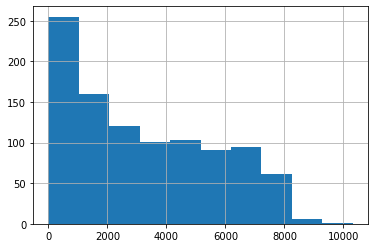

In [ ]:
has_mean_dist = hacks_dist_df['intergroup_spartial_dist'] != -1

hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Online'), 'intergroup_spartial_dist'].hist()

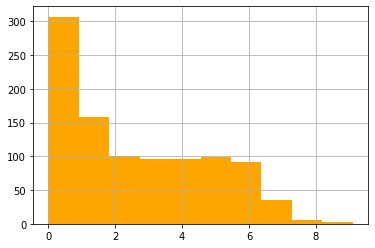

In [ ]:
hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Online'), 'intergroup_tz_dist'].hist(color='orange')

In [ ]:
mean_online_spartial_dist = np.mean(hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Online'), 'intergroup_spartial_dist'])
mean_offline_spartial_dist = np.mean(hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Offline'), 'intergroup_spartial_dist'])

print(f"Mean spartial distance for online hacks: {mean_online_spartial_dist}")
print(f"Mean spartial distance for offline hacks: {mean_offline_spartial_dist}")

Mean spartial distance for online hacks: 3203.9579782140277
Mean spartial distance for offline hacks: 886.1077066179057


In [ ]:
mean_online_tz_dist = np.mean(hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Online'), 'intergroup_tz_dist'])
mean_offline_tz_dist = np.mean(hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Offline'), 'intergroup_tz_dist'])

print(f"Mean time zone distance for online hacks: {mean_online_tz_dist}")
print(f"Mean time zone distance for offline hacks: {mean_offline_tz_dist}")

Mean time zone distance for online hacks: 2.5727911755225388
Mean time zone distance for offline hacks: 0.6534832969953034


In [ ]:
online_spartial_dists = hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Online'), 'intergroup_spartial_dist'].values
offline_spartial_dists = hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Offline'), 'intergroup_spartial_dist'].values

stat_t, p1 = stats.ttest_ind(online_spartial_dists, offline_spartial_dists)
print(f"T-statistic: {stat_t}, p-value {p1}")

stat_u, p2 = stats.mannwhitneyu(online_spartial_dists, offline_spartial_dists)
print(f"U-statistic: {stat_u}, p-value {p2}")

T-statistic: 37.94045323234398, p-value 9.465855241346177e-266
U-statistic: 552991.5, p-value 1.2771522710197892e-160


In [ ]:
online_tz_dists = hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Online'), 'intergroup_tz_dist'].values
offline_tz_dists = hacks_dist_df.loc[(has_mean_dist) & (hacks_dist_df['Location'] == 'Offline'), 'intergroup_tz_dist'].values

stat_t, p1 = stats.ttest_ind(online_tz_dists, offline_tz_dists)
print(f"T-statistic: {stat_t}, p-value {p1}")

stat_u, p2 = stats.mannwhitneyu(online_tz_dists, offline_tz_dists)
print(f"U-statistic: {stat_u}, p-value {p2}")

T-statistic: 35.56051481812971, p-value 5.0470438580872204e-238
U-statistic: 614166.0, p-value 1.6732984729938902e-139


## 5. Plotting some graphs

In [ ]:
grouped = hacks.groupby('year').count().sort_values('year' , ascending=True).reset_index()
# grouped['Start_month_year'] = str(grouped['year']) + ' ' + str(grouped['month'])

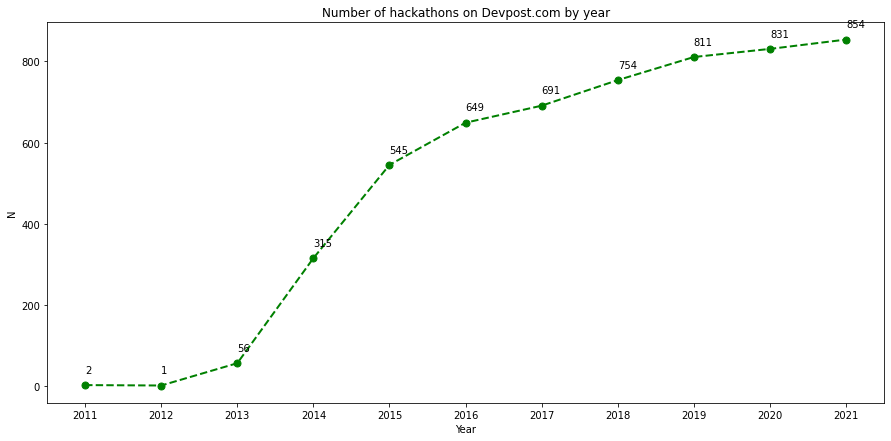

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(grouped['year'], grouped['URL'], color='green', label= 'N',  marker='o', linestyle='dashed',
     linewidth=2, markersize=7)
ax.set_title('Number of hackathons on Devpost.com by year')
ax.set_xlabel('Year')
ax.set_ylabel('N')
ax.xaxis.set_ticks(grouped['year'].values)

for i, row in grouped.iterrows():
    ax.annotate(str(row['URL']), xy=(row['year'], row['URL'] + 30))

plt.show()

In [ ]:
grouped = hacks.groupby(['year', 'Location']).count().sort_values('year' , ascending=True).reset_index()
grouped_online = grouped[grouped['Location']=='Online']
grouped_offline = grouped[grouped['Location']=='Offline']
# grouped['Start_month_year'] = str(grouped['year']) + ' ' + str(grouped['month'])

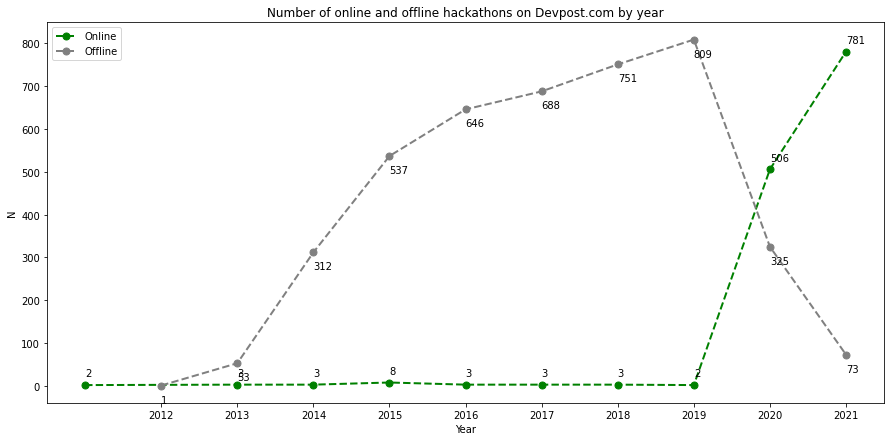

In [ ]:
colors = ['green', 'grey']
fig, ax = plt.subplots(figsize=(15, 7))
for c, loc in [['green','Online'],['grey','Offline']]:
  ax.plot(grouped[grouped.Location==loc].year, grouped[grouped.Location==loc].URL, color = c, label= 'N',  marker='o', linestyle='dashed', 
          linewidth=2, markersize=7)
  ax.set_title('Number of online and offline hackathons on Devpost.com by year')
  ax.set_xlabel('Year')
  ax.set_ylabel('N')
  ax.legend(['Online', 'Offline'])
  ax.xaxis.set_ticks(grouped[grouped.Location==loc].year.values)

for i, row in grouped_online.iterrows():
  ax.annotate(str(row['URL']), xy=(row['year'], row['URL'] + 20))
for i, row in grouped_offline.iterrows():
  ax.annotate(str(row['URL']), xy=(row['year'], row['URL'] - 40))

plt.show()

Now we will actually run Nominatim again in order to get the english country name by latitude and longtitude in order to aggregate hacks data

In [ ]:
import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [ ]:
city_standartized = []
country_standartized = []
for ind, row in tqdm(participants_locations.iterrows(), total=participants_locations.shape[0]):
  try:
    location = geolocator.reverse(str(row.lat)+","+str(row.lon), language='en')
    address = location.raw['address']
  except:
    print(f"Timeout error in row {ind}")
    country_standartized.append((None))
    city_standartized.append((None))
    continue
  try:
    country = address.get('country', '')
    country_standartized.append((country))
  except:
    country_standartized.append((None))
  try:
    city = address.get('city', '')
    city_standartized.append((city))
  except:
    city_standartized.append((None))

participants_locations['city_eng'] = [c for c in city_standartized]
participants_locations['country_eng'] = [c for c in country_standartized]
participants_locations.to_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/all_locations_cleaned_new_new.csv', index=False)

  3%|▎         | 332/11914 [02:54<2:11:06,  1.47it/s]

Timeout error in row 353


  3%|▎         | 378/11914 [03:17<2:14:01,  1.43it/s]

Timeout error in row 399


  3%|▎         | 381/11914 [03:19<2:21:38,  1.36it/s]

Timeout error in row 402


  3%|▎         | 386/11914 [03:22<2:15:39,  1.42it/s]

Timeout error in row 408


  4%|▍         | 450/11914 [03:55<2:16:51,  1.40it/s]

Timeout error in row 475


  4%|▍         | 453/11914 [03:56<1:33:29,  2.04it/s]

Timeout error in row 478


  4%|▍         | 456/11914 [03:58<1:29:54,  2.12it/s]

Timeout error in row 481


  4%|▍         | 473/11914 [04:07<2:12:51,  1.44it/s]

Timeout error in row 498


  4%|▍         | 533/11914 [04:39<2:08:44,  1.47it/s]

Timeout error in row 560


  5%|▍         | 546/11914 [04:46<2:17:55,  1.37it/s]

Timeout error in row 573


  5%|▍         | 548/11914 [04:47<2:24:54,  1.31it/s]

Timeout error in row 575


 13%|█▎        | 1511/11914 [12:44<1:58:50,  1.46it/s]

Timeout error in row 1632


 14%|█▎        | 1609/11914 [13:33<1:59:12,  1.44it/s]

Timeout error in row 1736


 29%|██▉       | 3477/11914 [28:55<1:38:46,  1.42it/s]

Timeout error in row 3649


 38%|███▊      | 4537/11914 [37:43<1:24:12,  1.46it/s]

Timeout error in row 4744


 40%|████      | 4788/11914 [39:47<1:20:59,  1.47it/s]

Timeout error in row 5003


 41%|████      | 4849/11914 [40:19<1:23:29,  1.41it/s]

Timeout error in row 5066


 41%|████      | 4878/11914 [40:35<1:28:00,  1.33it/s]

Timeout error in row 5096


 41%|████      | 4882/11914 [40:37<1:27:03,  1.35it/s]

Timeout error in row 5100


 52%|█████▏    | 6199/11914 [51:32<1:05:20,  1.46it/s]

Timeout error in row 6449


 54%|█████▍    | 6470/11914 [53:45<1:04:03,  1.42it/s]

Timeout error in row 6725


 56%|█████▋    | 6704/11914 [55:38<1:00:22,  1.44it/s]

Timeout error in row 6961


 61%|██████▏   | 7322/11914 [1:00:41<53:13,  1.44it/s]

Timeout error in row 7585


 71%|███████▏  | 8491/11914 [1:10:12<41:23,  1.38it/s]

Timeout error in row 8759


 78%|███████▊  | 9281/11914 [1:16:41<30:45,  1.43it/s]

Timeout error in row 9560


 78%|███████▊  | 9292/11914 [1:16:47<30:57,  1.41it/s]

Timeout error in row 9571


 96%|█████████▌| 11391/11914 [1:33:59<06:00,  1.45it/s]

Timeout error in row 11686


 96%|█████████▋| 11481/11914 [1:34:44<05:59,  1.20it/s]

Timeout error in row 11776


 96%|█████████▋| 11482/11914 [1:34:45<06:43,  1.07it/s]

Timeout error in row 11777


 96%|█████████▋| 11483/11914 [1:34:47<07:14,  1.01s/it]

Timeout error in row 11778


 97%|█████████▋| 11535/11914 [1:35:13<04:29,  1.40it/s]

Timeout error in row 11830


 97%|█████████▋| 11582/11914 [1:35:38<04:03,  1.36it/s]

Timeout error in row 11877


 98%|█████████▊| 11693/11914 [1:36:36<03:05,  1.19it/s]

Timeout error in row 11988


 99%|█████████▉| 11811/11914 [1:37:33<00:51,  2.02it/s]

Timeout error in row 12106


100%|██████████| 11914/11914 [1:38:24<00:00,  2.02it/s]


In [ ]:
participants_locations = pd.read_csv('/content/drive/MyDrive/Thesis/data/Data_all/all_locations_cleaned_new_new.csv')

In [ ]:
data = projects
data = data[['start_date_format', 'participants']]
data = (data.set_index('start_date_format')
   .apply(lambda x: x.str.split(',').explode())
   .reset_index()) 
data = data.merge(participants, left_on = 'participants',right_on = '0', how='left')
data = data[['start_date_format', 'country']]
data = data.merge(participants_locations, on = 'country', how='left')
data = data[['start_date_format', 'country_eng']]
data = data[~ data['country_eng'].isna()]
data['start_date_format'] = pd.to_datetime(data['start_date_format'])
data['year'] = data['start_date_format'].dt.year

In [ ]:
data_1 = data[['year', 'country_eng']]
grouped = data_1.groupby('year').nunique().sort_values('year' , ascending=True).reset_index()

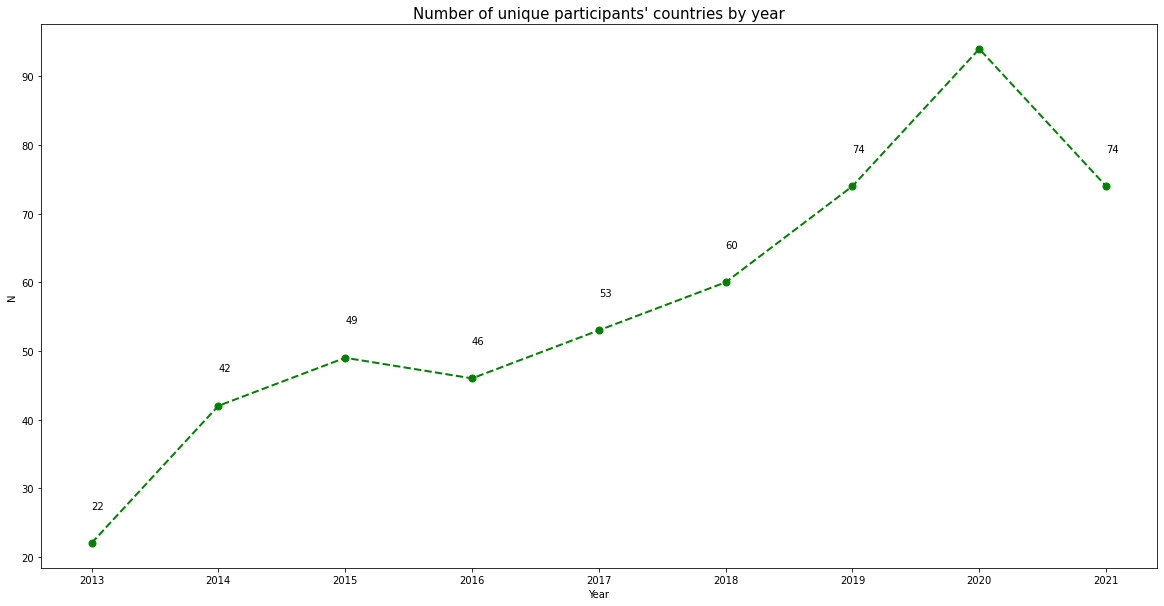

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(grouped['year'], grouped['country_eng'], color='green', label= 'N',  marker='o', linestyle='dashed',
     linewidth=2, markersize=7)
ax.set_title("Number of unique participants' countries by year", fontsize = 15)
ax.set_xlabel('Year')
ax.set_ylabel('N')
ax.xaxis.set_ticks(grouped['year'].values)

for i, row in grouped.iterrows():
    ax.annotate(str(row['country_eng'].astype('int')), xy=(row['year'], row['country_eng'] + 5))

plt.show()